## Corona Virus Ecuador

**Lenin G. Falconi**

**Marzo 20, 2020**

Para los cálculos presentados a continuación se considera como base:

https://towardsdatascience.com/covid-19-infection-in-italy-mathematical-models-and-predictions-7784b4d7dd8d

### Navegación por la presentación:
* Para ir hacia adelante: barra espaciadora
* Para retornar: shift + barra espaciadora

### Data
* La data utilizada se extrajo de las infografías del COE Nacional

### Objetivos:
* Aproximar un modelo de regresión logística para el comportamiento de contagio sin control en Ecuador
* Aproximar modelos de otros países. Para interpolar a los datos locales. (Pendiente)
* Corregir los cálculos del primer objetivo considerando el factor movilidad (Pendiente)

### Objetivos:
* Modelar considerando cómo el número de hospitales, número de respiradores, número de población con movilidad restringida? Para un enfoque de aprendizaje supervisado se require de datos para esta etapa. 


In [193]:
import os
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
%matplotlib inline

### Data
Datos extraídos de las infografías: https://www.gestionderiesgos.gob.ec/informes-de-situacion-covid-19-desde-el-13-de-marzo-del-2020/

In [194]:
df = pd.read_csv('pichincha.csv')
df


,Fecha,Confirmado
0,2020-03-13,3
1,2020-03-14,4
2,2020-03-15,6
3,2020-03-16,7
4,2020-03-17,8
5,2020-03-18,12
6,2020-03-19,12
7,2020-03-20,35
8,2020-03-21,44
9,2020-03-22,60


Se obtiene el gráfico original de los datos proveídos

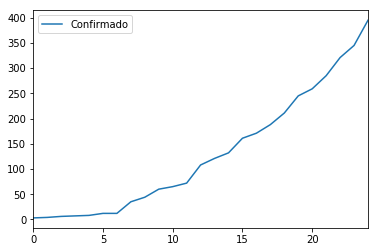

In [195]:
df.plot.line()


En forma similar a la referencia seguida en esta presentación, se convierte las fechas a números considerando al 1 de enero de 2020 como día 1 del año. Esto se podría replantear considerando más bien al inicio de la infección como el día 1. Posiblemente, por facilidad el autor original ha considerado usar este presupuesto para calcular el día de climax de infección.

In [196]:
FMT = '%Y-%m-%d'
date = df['Fecha']
df['Fecha'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-01", FMT)).days  )
df

,Fecha,Confirmado
0,72,3
1,73,4
2,74,6
3,75,7
4,76,8
5,77,12
6,78,12
7,79,35
8,80,44
9,81,60


Añado una columna con valores estimados de 2 a 7 veces el reportado que correspondería a casos que no han accedido a la prueba de corono virus

In [197]:
import random
df['Estimacion'] = df['Confirmado'].apply(lambda x: x*random.randint(2,7))
df

,Fecha,Confirmado,Estimacion
0,72,3,6
1,73,4,28
2,74,6,36
3,75,7,14
4,76,8,40
5,77,12,48
6,78,12,60
7,79,35,245
8,80,44,264
9,81,60,420


Esta nueva tabla de valores se guarda en un nuevo csv para facilidad de uso y verificar los cálculos en otras herramientas como *Matlab*

In [198]:
df.to_csv('pichincha_formatted.csv')


Extracción de los datos en variables $x$ y  $y$, para modelar una ecuación paramétrica del tipo $y=f(x)$

In [199]:
y = np.array(df['Confirmado'].values.tolist())
y

array([  3,   4,   6,   7,   8,  12,  12,  35,  44,  60,  65,  72, 108,
       121, 132, 161, 171, 188, 211, 245, 259, 285, 321, 345, 395])

In [200]:
# x = np.array(df.index.tolist())
# x = df.index.tolist()
x = np.array(df['Fecha'])
x

array([72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88,
       89, 90, 91, 92, 93, 94, 95, 96])

Se define el modelo logístico de acuerdo a la ecuación presentada en la publicación original. No obstante, ésta puede ser reformulada y debería considerar factores atenuantes. La ecuación es:

$y = c(1+e^{-\frac{x-b}{a}})^{-1}$

$y = c(1+e^{-\frac{x-b}{a}})^{-1}$

Donde:
* $y$ : número de contagiados o casos totales
* $x$ : día del año para el que se tiene un valor determinado de contagiados
* $a$ : velocidad de infección.
* $b$ : día en el que ocurre el máximo de infecciones
* $c$ : total de infectados en la población.

In [201]:
def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))

Ajuste de curva considerando valores iniciales indicados.

In [202]:
# p0=[10, 100, 2e3]
popt, pcov = curve_fit(logistic_model,x,y, p0=[15, 150, 3e6], method='lm', maxfev=4000)
popt

array([  4.99229047,  92.03561776, 544.34688059])

In [203]:
(a_, b_, c_) = popt

Matriz Covariante

In [204]:
np.diag(pcov)

array([1.20765126e-01, 1.12042952e+00, 2.82005899e+03])

Error standard para cada parámetro:

In [205]:
np.sqrt(np.diag(pcov))

array([ 0.34751277,  1.05850343, 53.1042276 ])

Con los datos adicionales a los dias 22 de marzo, el error del parámetro $c$ se reduce. Esto podría confirmar la necesidad de interpolar artificialmente los datos

In [206]:
errors_values = np.sqrt(np.diag(pcov))
errors_variables = ["a_err", "b_err", "c_err"]
errors_dict = dict(zip(errors_variables, errors_values))
errors_dict

{'a_err': 0.3475127710473816,
 'b_err': 1.058503432888182,
 'c_err': 53.1042276031144}

Para los mismos datos se hace una predicción según el ajuste de curva, obteniendo los siguientes valores. Note que no se han redondeado los números a valores enteros.

In [207]:
y_pred = logistic_model(x, *popt)
y_pred

array([  9.66356791,  11.76045163,  14.30016612,  17.37045346,
        21.07373181,  25.52828076,  30.86888207,  37.24654482,
        44.8268321 ,  53.78620332,  64.30572782,  76.56156528,
        90.71181714, 106.87980555, 125.13457804, 145.47043484,
       167.78836724, 191.88315087, 217.44001877, 244.04394893,
       271.20252661, 298.38045282, 325.04090901, 350.68716974,
       374.89778774])

En azul se tiene los datos originales y en la curva naranja la curva ajustada

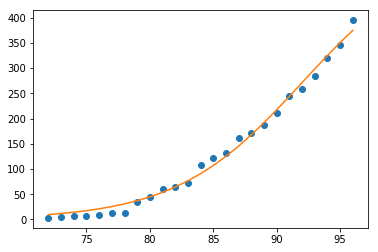

In [208]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
# ax.plot(x, y, '--k')
ax.plot(x, y, 'o')
ax.plot(x, y_pred, '-')

In [209]:
results = {'infection_speed':a_, 'final_day': b_, 'total_infected':c_}

Número total de personas infectadas (en miles):

In [210]:
results['total_infected']

544.3468805926507

In [211]:
results['total_infected']+errors_dict['c_err']

597.4511081957651

El pico de infección se obtiene para el día:

In [212]:
sol = int(fsolve(lambda x : logistic_model(x,*popt) - int(c_),b_))
sol

128

La fecha esperada para el pico de infección es:

In [213]:
specific_date = datetime(2020, 1, 1)
new_date = specific_date + timedelta(sol)
print('año:{} mes:{} día: {}'.format(new_date.year, new_date.month, new_date.day))

año:2020 mes:5 día: 8


Cuántos casos se espera para hoy?

In [214]:
dt = datetime.today()
target_date = datetime(dt.year, dt.month, dt.day)
initial_date = datetime(2020, 1, 1)
x_day = (target_date-initial_date).days
print('fecha objetivo {} corresponde al día {} con respecto al 01/01/20'.format(target_date, x_day))
y_day = logistic_model(x_day, *popt)
print('Predicción del número de infecciones: {}'.format(y_day))

fecha objetivo 2020-04-06 00:00:00 corresponde al día 96 con respecto al 01/01/20
Predicción del número de infecciones: 374.89778774145196


Para la fecha de máxima infecciones, cuántas infecciones?

In [215]:
target_date = datetime(2020, 5, 31)
initial_date = datetime(2020, 1, 1)
x_day = (target_date-initial_date).days
print('target date {} corresponds to day # {}'.format(target_date, x_day))
y_day = logistic_model(x_day, *popt)
print('Predicted number of infections: {}'.format(y_day))

target date 2020-05-31 00:00:00 corresponds to day # 151
Predicted number of infections: 544.3428405853363


In [216]:
y_day+errors_dict['c_err']

597.4470681884507

## Gráfica de proyecciones al 31 de Mayo
Considerando los datos proporcionados hasta el 6 de abril, se presenta una proyección gráfica hasta el 13 de abril. 

In [217]:
import matplotlib.dates as mdates
formatter = mdates.DateFormatter('%b %d')
target_date = datetime(2020, 5, 31)
initial_date = datetime(2020, 1, 1)
x_end = (target_date-initial_date).days
x_pronos = np.arange(start=x[0], stop=x_end, step=1)
y_pronos = logistic_model(x_pronos, *popt)

## Gráfica de proyecciones al 31 de Mayo
Considerando los datos proporcionados hasta el 18 de marzo, se presenta una proyección gráfica hasta el 13 de abril. 

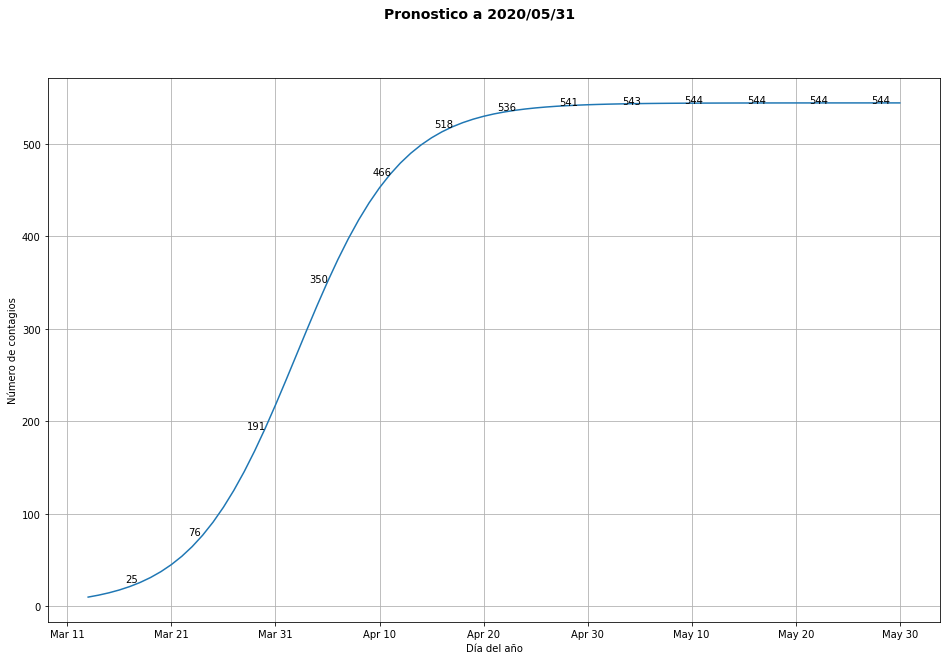

In [218]:
fig, ax = plt.subplots(1, 1, figsize=(16, 10))
fig.suptitle('Pronostico a 2020/05/31', fontsize=14, fontweight='bold')
ax.plot(x_pronos, y_pronos, '-')
yi_1 = 0
cont = 0
for xi,yi in zip(x_pronos,y_pronos):
    if (yi>yi_1) and (cont==5): 
        ax.text(xi-0.8, yi, "%i" %yi, ha='center') #"%.2f"
    yi_1+=1
    cont+=1
    if cont>5:
        cont=0
ax.xaxis.set_major_formatter(formatter)
ax.set_xlabel('Día del año')
ax.set_ylabel('Número de contagios')
ax.grid(True)
fig.savefig('images/proyectionApril30.png')

<center>
<img src="images/proyectionApril30.png"/>
</center>

Por revisar:
* Usar red neuronal para mapear los datos. Generando un overfitting para generar un incremento artificial de datos, teniendo predicciones para intervalos intermedios de tiempo. Con esta data aumentada, realizar nuevamente el ajuste del modelo, ya que la interpretación de los parámetros de la ecuación permite interpretar información últil.

* Entrenar una red considerando datos más abundantes de otro país. No obstante esto genera el problema de que las condiciones de cada país son diferentes y por tanto la respuesta de cada país es diferente. Por tanto, se pensaría en un modelo global que sea la suma de todos. Luego se podría tratar de especializar las últimas capas del modelo en función de la data particular del país al estilo *transfer learning*.

## Conclusiones
* Quédate en la casa. Al momento los datos indicarían que estamos subiendo por la curva de infección en el primer estadio. 
* Es necesario relantizar dicha pendiente para no colapsar los sistemas médicos.
* Es necesario que las autoridades y otros sectores involucrados traten de proveerse de insumos médicos adicionales. A más de las máscaras, debería observarse la necesidad de respiradores artificiales.

## Conclusiones

* Inicialmente, esto es con datos sólo hasta el 18 de marzo se estimaba, considerando una población total en el Ecuador de 17 millones (https://countrymeters.info/es/Ecuador), que 15 millones terminarían contagiados; en la situación sin restricción de movilidad, implica un contagio del **89%**, estimando alcanzar el pico en 93 días más.
* Con los datos actualizados a 22 de marzo se espera menos contagios y alcanzar el límite de contagios al 14 de Abril de 2020; es decir en 46 días más.
* Los cálculos aquí presentados son referenciales en función de la información disponible y de los modelos presentados. Dado que los factores de restricción de movilidad ya están en ejecución se esperaría que el número de infectados sea menor. Esta es una aproximación simplista del escenario. 




### Conclusiones

* Es necesario realizar suficientes pruebas para poder mejorar la predicción del modelo.
* Los resultados han ido cambiando en función de los datos acumulados.
* Este modelo no considera las medidas puestas en ejecución.
* Se espera que al 8 de Mayo se alcance el máximo en función de los datos proporcionados.

In [219]:
population = 2.5e6
z = results['total_infected']+errors_dict['c_err']
rate = z/population*100.0
print(rate)
days_remaining = sol-df['Fecha'].iloc[0]
print(days_remaining)

0.023898044327830603
56


### Artificial Neural Network

In [220]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop

In [221]:
def baseline_model():
    model = Sequential()
    model.add(Dense(512, input_dim=1, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=RMSprop(1e-4), metrics=['mae', 'mse'])
    return model

model = baseline_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_157 (Dense)            (None, 512)               1024      
_________________________________________________________________
dense_158 (Dense)            (None, 512)               262656    
_________________________________________________________________
dense_159 (Dense)            (None, 512)               262656    
_________________________________________________________________
dense_160 (Dense)            (None, 512)               262656    
_________________________________________________________________
dense_161 (Dense)            (None, 512)               262656    
_________________________________________________________________
dropout_27 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_162 (Dense)            (None, 1)                 513       
Total para

In [222]:
x_stats = df["Fecha"].describe()
x_stats

count    25.000000
mean     84.000000
std       7.359801
min      72.000000
25%      78.000000
50%      84.000000
75%      90.000000
max      96.000000
Name: Fecha, dtype: float64

In [223]:
y_stats = df["Confirmado"].describe()
y_stats

count     25.000000
mean     130.800000
std      121.465702
min        3.000000
25%       12.000000
50%      108.000000
75%      211.000000
max      395.000000
Name: Confirmado, dtype: float64

In [224]:
x_norm = (np.array(x)-x_stats['mean'])/x_stats['std']
x_norm

array([-1.63047893, -1.49460569, -1.35873244, -1.2228592 , -1.08698595,
       -0.95111271, -0.81523946, -0.67936622, -0.54349298, -0.40761973,
       -0.27174649, -0.13587324,  0.        ,  0.13587324,  0.27174649,
        0.40761973,  0.54349298,  0.67936622,  0.81523946,  0.95111271,
        1.08698595,  1.2228592 ,  1.35873244,  1.49460569,  1.63047893])

In [225]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
estimator = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=5, verbose=1)
kfold = KFold(n_splits=10)
y_ = np.array(y)
results = cross_val_score(estimator, x_norm, y_, cv=kfold)
print("baseline: {} mse {}".format(results.mean(), results.std()))

Epoch 1/100
22/22 [==============================] - 2s 77ms/step - loss: 35513.6919 - mean_absolute_error: 147.9664 - mean_squared_error: 35513.6919
Epoch 2/100
22/22 [==============================] - 0s 3ms/step - loss: 35437.6935 - mean_absolute_error: 147.7535 - mean_squared_error: 35437.6935
Epoch 3/100
22/22 [==============================] - 0s 3ms/step - loss: 35323.1204 - mean_absolute_error: 147.4016 - mean_squared_error: 35323.1204
Epoch 4/100
22/22 [==============================] - 0s 3ms/step - loss: 35174.9154 - mean_absolute_error: 146.9271 - mean_squared_error: 35174.9154
Epoch 5/100
22/22 [==============================] - 0s 4ms/step - loss: 34930.8855 - mean_absolute_error: 146.2230 - mean_squared_error: 34930.8855
Epoch 6/100
22/22 [==============================] - 0s 3ms/step - loss: 34558.3080 - mean_absolute_error: 144.9585 - mean_squared_error: 34558.3080
Epoch 7/100
22/22 [==============================] - 0s 3ms/step - loss: 33986.4076 - mean_absolute_error

22/22 [==============================] - 0s 4ms/step - loss: 222.7476 - mean_absolute_error: 13.2186 - mean_squared_error: 222.7476
Epoch 57/100
22/22 [==============================] - 0s 4ms/step - loss: 310.1539 - mean_absolute_error: 14.6401 - mean_squared_error: 310.1539
Epoch 58/100
22/22 [==============================] - 0s 4ms/step - loss: 326.6266 - mean_absolute_error: 14.9107 - mean_squared_error: 326.6266
Epoch 59/100
22/22 [==============================] - 0s 4ms/step - loss: 304.4039 - mean_absolute_error: 14.0646 - mean_squared_error: 304.4039
Epoch 60/100
22/22 [==============================] - 0s 4ms/step - loss: 156.8753 - mean_absolute_error: 10.8500 - mean_squared_error: 156.8753
Epoch 61/100
22/22 [==============================] - 0s 4ms/step - loss: 232.9674 - mean_absolute_error: 11.9217 - mean_squared_error: 232.9674
Epoch 62/100
22/22 [==============================] - 0s 4ms/step - loss: 142.0355 - mean_absolute_error: 10.5825 - mean_squared_error: 142.035

22/22 [==============================] - 0s 4ms/step - loss: 27758.8845 - mean_absolute_error: 132.0469 - mean_squared_error: 27758.8845
Epoch 13/100
22/22 [==============================] - 0s 4ms/step - loss: 25422.5975 - mean_absolute_error: 128.0553 - mean_squared_error: 25422.5975
Epoch 14/100
22/22 [==============================] - 0s 4ms/step - loss: 23207.7774 - mean_absolute_error: 122.4909 - mean_squared_error: 23207.7774
Epoch 15/100
22/22 [==============================] - 0s 4ms/step - loss: 20004.6450 - mean_absolute_error: 115.2918 - mean_squared_error: 20004.6450
Epoch 16/100
22/22 [==============================] - 0s 4ms/step - loss: 17548.6960 - mean_absolute_error: 109.0495 - mean_squared_error: 17548.6960
Epoch 17/100
22/22 [==============================] - 0s 4ms/step - loss: 14068.8386 - mean_absolute_error: 99.4378 - mean_squared_error: 14068.8386
Epoch 18/100
22/22 [==============================] - 0s 4ms/step - loss: 11555.7554 - mean_absolute_error: 91.018

22/22 [==============================] - 0s 4ms/step - loss: 209.3864 - mean_absolute_error: 10.9461 - mean_squared_error: 209.3864
Epoch 69/100
22/22 [==============================] - 0s 4ms/step - loss: 137.5701 - mean_absolute_error: 9.3162 - mean_squared_error: 137.5701
Epoch 70/100
22/22 [==============================] - 0s 4ms/step - loss: 249.3449 - mean_absolute_error: 12.2408 - mean_squared_error: 249.3449
Epoch 71/100
22/22 [==============================] - 0s 4ms/step - loss: 120.6211 - mean_absolute_error: 8.7247 - mean_squared_error: 120.6211
Epoch 72/100
22/22 [==============================] - 0s 4ms/step - loss: 197.1108 - mean_absolute_error: 11.5272 - mean_squared_error: 197.1108
Epoch 73/100
22/22 [==============================] - 0s 4ms/step - loss: 271.1003 - mean_absolute_error: 11.0937 - mean_squared_error: 271.1003
Epoch 74/100
22/22 [==============================] - 0s 4ms/step - loss: 193.0819 - mean_absolute_error: 10.5412 - mean_squared_error: 193.0819


22/22 [==============================] - 0s 5ms/step - loss: 4957.0469 - mean_absolute_error: 62.4194 - mean_squared_error: 4957.0469
Epoch 24/100
22/22 [==============================] - 0s 5ms/step - loss: 3156.5450 - mean_absolute_error: 51.0559 - mean_squared_error: 3156.5450
Epoch 25/100
22/22 [==============================] - 0s 5ms/step - loss: 1980.1505 - mean_absolute_error: 40.8708 - mean_squared_error: 1980.1505
Epoch 26/100
22/22 [==============================] - 0s 4ms/step - loss: 1054.3133 - mean_absolute_error: 28.9043 - mean_squared_error: 1054.3133
Epoch 27/100
22/22 [==============================] - 0s 6ms/step - loss: 700.9902 - mean_absolute_error: 23.6952 - mean_squared_error: 700.9902
Epoch 28/100
22/22 [==============================] - 0s 5ms/step - loss: 517.2784 - mean_absolute_error: 19.4239 - mean_squared_error: 517.2784
Epoch 29/100
22/22 [==============================] - 0s 6ms/step - loss: 441.8022 - mean_absolute_error: 17.8933 - mean_squared_error:

22/22 [==============================] - 0s 6ms/step - loss: 145.8824 - mean_absolute_error: 7.8617 - mean_squared_error: 145.8824
Epoch 80/100
22/22 [==============================] - 0s 5ms/step - loss: 151.9768 - mean_absolute_error: 8.3167 - mean_squared_error: 151.9768
Epoch 81/100
22/22 [==============================] - 0s 4ms/step - loss: 365.5246 - mean_absolute_error: 12.1302 - mean_squared_error: 365.5246
Epoch 82/100
22/22 [==============================] - 0s 7ms/step - loss: 129.0078 - mean_absolute_error: 7.7426 - mean_squared_error: 129.0078
Epoch 83/100
22/22 [==============================] - 0s 5ms/step - loss: 135.4256 - mean_absolute_error: 7.7122 - mean_squared_error: 135.4256
Epoch 84/100
22/22 [==============================] - 0s 5ms/step - loss: 163.9952 - mean_absolute_error: 8.0725 - mean_squared_error: 163.9952
Epoch 85/100
22/22 [==============================] - 0s 5ms/step - loss: 322.0611 - mean_absolute_error: 11.2556 - mean_squared_error: 322.0611
Epo

22/22 [==============================] - 0s 5ms/step - loss: 298.8072 - mean_absolute_error: 13.1280 - mean_squared_error: 298.8072
Epoch 35/100
22/22 [==============================] - 0s 4ms/step - loss: 308.1738 - mean_absolute_error: 13.3967 - mean_squared_error: 308.1738
Epoch 36/100
22/22 [==============================] - 0s 4ms/step - loss: 272.6392 - mean_absolute_error: 12.9692 - mean_squared_error: 272.6392
Epoch 37/100
22/22 [==============================] - 0s 4ms/step - loss: 385.8249 - mean_absolute_error: 14.9339 - mean_squared_error: 385.8249
Epoch 38/100
22/22 [==============================] - 0s 4ms/step - loss: 274.4655 - mean_absolute_error: 12.3330 - mean_squared_error: 274.4655
Epoch 39/100
22/22 [==============================] - 0s 4ms/step - loss: 266.6883 - mean_absolute_error: 12.2102 - mean_squared_error: 266.6883
Epoch 40/100
22/22 [==============================] - 0s 4ms/step - loss: 274.1937 - mean_absolute_error: 13.5100 - mean_squared_error: 274.193

22/22 [==============================] - 0s 4ms/step - loss: 254.9245 - mean_absolute_error: 10.8574 - mean_squared_error: 254.9245
Epoch 91/100
22/22 [==============================] - 0s 5ms/step - loss: 134.7446 - mean_absolute_error: 8.7516 - mean_squared_error: 134.7446
Epoch 92/100
22/22 [==============================] - 0s 8ms/step - loss: 206.4612 - mean_absolute_error: 9.8730 - mean_squared_error: 206.4612
Epoch 93/100
22/22 [==============================] - 0s 4ms/step - loss: 87.2960 - mean_absolute_error: 7.0365 - mean_squared_error: 87.2960
Epoch 94/100
22/22 [==============================] - 0s 4ms/step - loss: 186.4228 - mean_absolute_error: 9.2883 - mean_squared_error: 186.4228
Epoch 95/100
22/22 [==============================] - 0s 4ms/step - loss: 171.5722 - mean_absolute_error: 8.3210 - mean_squared_error: 171.5722
Epoch 96/100
22/22 [==============================] - 0s 7ms/step - loss: 97.0323 - mean_absolute_error: 7.7023 - mean_squared_error: 97.0323
Epoch 97

22/22 [==============================] - 0s 4ms/step - loss: 216.7940 - mean_absolute_error: 11.3516 - mean_squared_error: 216.7940
Epoch 45/100
22/22 [==============================] - 0s 6ms/step - loss: 258.4665 - mean_absolute_error: 13.9486 - mean_squared_error: 258.4665
Epoch 46/100
22/22 [==============================] - 0s 7ms/step - loss: 205.7966 - mean_absolute_error: 11.5249 - mean_squared_error: 205.7966
Epoch 47/100
22/22 [==============================] - 0s 4ms/step - loss: 334.1713 - mean_absolute_error: 13.4231 - mean_squared_error: 334.1713
Epoch 48/100
22/22 [==============================] - 0s 4ms/step - loss: 272.3492 - mean_absolute_error: 14.3619 - mean_squared_error: 272.3492
Epoch 49/100
22/22 [==============================] - 0s 4ms/step - loss: 300.6621 - mean_absolute_error: 14.0997 - mean_squared_error: 300.6621
Epoch 50/100
22/22 [==============================] - 0s 4ms/step - loss: 198.9022 - mean_absolute_error: 10.7508 - mean_squared_error: 198.902

3/3 [==============================] - 1s 393ms/step
Epoch 1/100
23/23 [==============================] - 3s 120ms/step - loss: 31573.4871 - mean_absolute_error: 127.6430 - mean_squared_error: 31573.4871
Epoch 2/100
23/23 [==============================] - 0s 4ms/step - loss: 31508.5160 - mean_absolute_error: 127.4277 - mean_squared_error: 31508.5160
Epoch 3/100
23/23 [==============================] - 0s 7ms/step - loss: 31406.6214 - mean_absolute_error: 127.0454 - mean_squared_error: 31406.6214
Epoch 4/100
23/23 [==============================] - 0s 4ms/step - loss: 31216.2056 - mean_absolute_error: 126.4725 - mean_squared_error: 31216.2056
Epoch 5/100
23/23 [==============================] - 0s 4ms/step - loss: 30932.2884 - mean_absolute_error: 125.6211 - mean_squared_error: 30932.2884
Epoch 6/100
23/23 [==============================] - 0s 4ms/step - loss: 30488.3337 - mean_absolute_error: 124.4212 - mean_squared_error: 30488.3337
Epoch 7/100
23/23 [==============================] 

23/23 [==============================] - 0s 4ms/step - loss: 201.0573 - mean_absolute_error: 11.8681 - mean_squared_error: 201.0573
Epoch 56/100
23/23 [==============================] - 0s 8ms/step - loss: 291.5944 - mean_absolute_error: 11.7772 - mean_squared_error: 291.5944
Epoch 57/100
23/23 [==============================] - 0s 5ms/step - loss: 422.9599 - mean_absolute_error: 14.2360 - mean_squared_error: 422.9599
Epoch 58/100
23/23 [==============================] - 0s 4ms/step - loss: 172.3255 - mean_absolute_error: 9.8839 - mean_squared_error: 172.3255
Epoch 59/100
23/23 [==============================] - 0s 4ms/step - loss: 200.2521 - mean_absolute_error: 9.9744 - mean_squared_error: 200.2521
Epoch 60/100
23/23 [==============================] - 0s 5ms/step - loss: 298.3764 - mean_absolute_error: 11.8341 - mean_squared_error: 298.3764
Epoch 61/100
23/23 [==============================] - 0s 8ms/step - loss: 149.4879 - mean_absolute_error: 9.4285 - mean_squared_error: 149.4879
E

23/23 [==============================] - 0s 4ms/step - loss: 25898.4692 - mean_absolute_error: 116.1595 - mean_squared_error: 25898.4692
Epoch 12/100
23/23 [==============================] - 0s 5ms/step - loss: 24398.4513 - mean_absolute_error: 114.0258 - mean_squared_error: 24398.4513
Epoch 13/100
23/23 [==============================] - 0s 6ms/step - loss: 22852.5654 - mean_absolute_error: 111.4549 - mean_squared_error: 22852.5654
Epoch 14/100
23/23 [==============================] - 0s 8ms/step - loss: 20853.8924 - mean_absolute_error: 107.4073 - mean_squared_error: 20853.8924
Epoch 15/100
23/23 [==============================] - 0s 7ms/step - loss: 18647.3970 - mean_absolute_error: 103.4620 - mean_squared_error: 18647.3970
Epoch 16/100
23/23 [==============================] - 0s 4ms/step - loss: 16612.5936 - mean_absolute_error: 98.6464 - mean_squared_error: 16612.5936
Epoch 17/100
23/23 [==============================] - 0s 4ms/step - loss: 14071.8018 - mean_absolute_error: 92.503

23/23 [==============================] - 0s 12ms/step - loss: 109.2209 - mean_absolute_error: 7.9047 - mean_squared_error: 109.2209
Epoch 68/100
23/23 [==============================] - 0s 4ms/step - loss: 146.3277 - mean_absolute_error: 8.2961 - mean_squared_error: 146.3277
Epoch 69/100
23/23 [==============================] - 0s 7ms/step - loss: 265.5053 - mean_absolute_error: 11.6026 - mean_squared_error: 265.5053
Epoch 70/100
23/23 [==============================] - 0s 11ms/step - loss: 139.7029 - mean_absolute_error: 9.1307 - mean_squared_error: 139.7029
Epoch 71/100
23/23 [==============================] - 0s 4ms/step - loss: 85.8427 - mean_absolute_error: 7.5190 - mean_squared_error: 85.8427
Epoch 72/100
23/23 [==============================] - 0s 4ms/step - loss: 184.8918 - mean_absolute_error: 9.0252 - mean_squared_error: 184.8918
Epoch 73/100
23/23 [==============================] - 0s 4ms/step - loss: 127.2243 - mean_absolute_error: 8.7713 - mean_squared_error: 127.2243
Epoc

23/23 [==============================] - 0s 4ms/step - loss: 1447.5826 - mean_absolute_error: 34.9768 - mean_squared_error: 1447.5826
Epoch 23/100
23/23 [==============================] - 0s 7ms/step - loss: 1060.5599 - mean_absolute_error: 29.7814 - mean_squared_error: 1060.5599
Epoch 24/100
23/23 [==============================] - 0s 9ms/step - loss: 862.4812 - mean_absolute_error: 26.4500 - mean_squared_error: 862.4812
Epoch 25/100
23/23 [==============================] - 0s 4ms/step - loss: 584.3503 - mean_absolute_error: 20.9542 - mean_squared_error: 584.3503
Epoch 26/100
23/23 [==============================] - 0s 4ms/step - loss: 699.4958 - mean_absolute_error: 22.8413 - mean_squared_error: 699.4958
Epoch 27/100
23/23 [==============================] - 0s 11ms/step - loss: 693.3481 - mean_absolute_error: 22.7692 - mean_squared_error: 693.3481
Epoch 28/100
23/23 [==============================] - 0s 7ms/step - loss: 462.5781 - mean_absolute_error: 18.2568 - mean_squared_error: 46

23/23 [==============================] - 0s 4ms/step - loss: 110.5974 - mean_absolute_error: 7.7732 - mean_squared_error: 110.5974
Epoch 79/100
23/23 [==============================] - 0s 4ms/step - loss: 144.1199 - mean_absolute_error: 8.4017 - mean_squared_error: 144.1199
Epoch 80/100
23/23 [==============================] - 0s 10ms/step - loss: 130.5673 - mean_absolute_error: 8.2099 - mean_squared_error: 130.5673
Epoch 81/100
23/23 [==============================] - 0s 7ms/step - loss: 131.8568 - mean_absolute_error: 8.0162 - mean_squared_error: 131.8568
Epoch 82/100
23/23 [==============================] - 0s 4ms/step - loss: 95.9618 - mean_absolute_error: 7.2317 - mean_squared_error: 95.9618
Epoch 83/100
23/23 [==============================] - 0s 5ms/step - loss: 357.1335 - mean_absolute_error: 12.6457 - mean_squared_error: 357.1335
Epoch 84/100
23/23 [==============================] - 0s 15ms/step - loss: 168.2032 - mean_absolute_error: 9.2952 - mean_squared_error: 168.2032
Epoc

23/23 [==============================] - 0s 5ms/step - loss: 369.5667 - mean_absolute_error: 15.9211 - mean_squared_error: 369.5667
Epoch 34/100
23/23 [==============================] - 0s 13ms/step - loss: 409.7384 - mean_absolute_error: 17.1177 - mean_squared_error: 409.7384
Epoch 35/100
23/23 [==============================] - 0s 9ms/step - loss: 420.2836 - mean_absolute_error: 17.2005 - mean_squared_error: 420.2836
Epoch 36/100
23/23 [==============================] - 0s 7ms/step - loss: 370.2422 - mean_absolute_error: 16.7957 - mean_squared_error: 370.2422
Epoch 37/100
23/23 [==============================] - 0s 10ms/step - loss: 467.4864 - mean_absolute_error: 18.2877 - mean_squared_error: 467.4864
Epoch 38/100
23/23 [==============================] - 0s 5ms/step - loss: 278.4756 - mean_absolute_error: 14.2481 - mean_squared_error: 278.4756
Epoch 39/100
23/23 [==============================] - 0s 9ms/step - loss: 257.7162 - mean_absolute_error: 13.6100 - mean_squared_error: 257.7

23/23 [==============================] - 0s 11ms/step - loss: 119.0216 - mean_absolute_error: 7.5655 - mean_squared_error: 119.0216
Epoch 90/100
23/23 [==============================] - 0s 6ms/step - loss: 91.1563 - mean_absolute_error: 6.3058 - mean_squared_error: 91.1563
Epoch 91/100
23/23 [==============================] - 0s 4ms/step - loss: 60.0890 - mean_absolute_error: 5.9445 - mean_squared_error: 60.0890
Epoch 92/100
23/23 [==============================] - 0s 4ms/step - loss: 96.8260 - mean_absolute_error: 7.1522 - mean_squared_error: 96.8260
Epoch 93/100
23/23 [==============================] - 0s 12ms/step - loss: 270.6848 - mean_absolute_error: 9.3440 - mean_squared_error: 270.6848
Epoch 94/100
23/23 [==============================] - 0s 10ms/step - loss: 267.4429 - mean_absolute_error: 11.1611 - mean_squared_error: 267.4429
Epoch 95/100
23/23 [==============================] - 0s 8ms/step - loss: 164.0268 - mean_absolute_error: 8.1321 - mean_squared_error: 164.0268
Epoch 9

23/23 [==============================] - 0s 5ms/step - loss: 181.0495 - mean_absolute_error: 10.9039 - mean_squared_error: 181.0495
Epoch 45/100
23/23 [==============================] - 0s 8ms/step - loss: 202.4994 - mean_absolute_error: 11.7712 - mean_squared_error: 202.4994
Epoch 46/100
23/23 [==============================] - 0s 13ms/step - loss: 149.6846 - mean_absolute_error: 10.2849 - mean_squared_error: 149.6846
Epoch 47/100
23/23 [==============================] - 0s 4ms/step - loss: 135.6686 - mean_absolute_error: 9.4057 - mean_squared_error: 135.6686
Epoch 48/100
23/23 [==============================] - 0s 6ms/step - loss: 220.5263 - mean_absolute_error: 12.7870 - mean_squared_error: 220.5263
Epoch 49/100
23/23 [==============================] - 0s 6ms/step - loss: 142.3498 - mean_absolute_error: 10.3078 - mean_squared_error: 142.3498
Epoch 50/100
23/23 [==============================] - 0s 4ms/step - loss: 150.3155 - mean_absolute_error: 10.5437 - mean_squared_error: 150.315

2/2 [==============================] - 3s 1s/step
baseline: -208.28445653915406 mse 251.21643638857202


In [226]:
y_reg = model.predict(x_norm.reshape(-1,1))
y_reg

array([[-0.04394488],
       [-0.04028275],
       [-0.03662068],
       [-0.03295864],
       [-0.02929657],
       [-0.02563448],
       [-0.02197244],
       [-0.01831034],
       [-0.01464829],
       [-0.01098622],
       [-0.00732414],
       [-0.00366207],
       [ 0.        ],
       [-0.00177824],
       [-0.00355647],
       [-0.00533471],
       [-0.00711294],
       [-0.00889118],
       [-0.01066942],
       [-0.01244766],
       [-0.01422589],
       [-0.01600413],
       [-0.01778235],
       [-0.01956059],
       [-0.02133884]], dtype=float32)

In [227]:
# from sklearn.model_selection import train_test_split
# x_ = np.array(x)
# y_ = np.array(y)
# x_train, x_test, y_train, y_test = train_test_split(x_,y_, test_size=0.2, random_state=42, shuffle=True)
# print('Numero de casos de entrenamiento: {}'.format(len(x_train)))
# print('Numero de casos de testeo: {}'.format(len(x_test)))
# print("x: {}".format(x_))
# print("y: {}".format(y_))
# print("x_train: {}".format(x_train))
# print("y_train: {}".format(y_train))
# print("x_test: {}".format(x_test))
# print("y_test: {}".format(y_test))
      

In [228]:
history = model.fit(x_norm, y, verbose=1, epochs=1500)

Epoch 1/1500
25/25 [==============================] - 3s 136ms/step - loss: 31276.6641 - mean_absolute_error: 130.8195 - mean_squared_error: 31276.6641
Epoch 2/1500
25/25 [==============================] - 0s 672us/step - loss: 31258.3652 - mean_absolute_error: 130.7603 - mean_squared_error: 31258.3652
Epoch 3/1500
25/25 [==============================] - 0s 708us/step - loss: 31244.9395 - mean_absolute_error: 130.7143 - mean_squared_error: 31244.9395
Epoch 4/1500
25/25 [==============================] - 0s 791us/step - loss: 31233.4492 - mean_absolute_error: 130.6702 - mean_squared_error: 31233.4492
Epoch 5/1500
25/25 [==============================] - 0s 703us/step - loss: 31219.9316 - mean_absolute_error: 130.6243 - mean_squared_error: 31219.9316
Epoch 6/1500
25/25 [==============================] - 0s 870us/step - loss: 31206.0449 - mean_absolute_error: 130.5769 - mean_squared_error: 31206.0449
Epoch 7/1500
25/25 [==============================] - 0s 3ms/step - loss: 31190.0059 - m

25/25 [==============================] - 0s 864us/step - loss: 19302.6562 - mean_absolute_error: 106.4959 - mean_squared_error: 19302.6562
Epoch 56/1500
25/25 [==============================] - 0s 782us/step - loss: 18467.8418 - mean_absolute_error: 104.4404 - mean_squared_error: 18467.8418
Epoch 57/1500
25/25 [==============================] - 0s 787us/step - loss: 17881.6211 - mean_absolute_error: 103.1344 - mean_squared_error: 17881.6211
Epoch 58/1500
25/25 [==============================] - 0s 909us/step - loss: 17437.6445 - mean_absolute_error: 102.1025 - mean_squared_error: 17437.6445
Epoch 59/1500
25/25 [==============================] - 0s 662us/step - loss: 16781.2578 - mean_absolute_error: 100.3529 - mean_squared_error: 16781.2578
Epoch 60/1500
25/25 [==============================] - 0s 1ms/step - loss: 16300.6777 - mean_absolute_error: 98.5457 - mean_squared_error: 16300.6777
Epoch 61/1500
25/25 [==============================] - 0s 4ms/step - loss: 15095.6875 - mean_absolu

Epoch 111/1500
25/25 [==============================] - 0s 690us/step - loss: 338.1154 - mean_absolute_error: 15.4092 - mean_squared_error: 338.1154
Epoch 112/1500
25/25 [==============================] - 0s 805us/step - loss: 369.4389 - mean_absolute_error: 16.4229 - mean_squared_error: 369.4389
Epoch 113/1500
25/25 [==============================] - 0s 726us/step - loss: 456.5798 - mean_absolute_error: 16.4960 - mean_squared_error: 456.5798
Epoch 114/1500
25/25 [==============================] - 0s 864us/step - loss: 328.0727 - mean_absolute_error: 14.7619 - mean_squared_error: 328.0727
Epoch 115/1500
25/25 [==============================] - 0s 901us/step - loss: 328.5837 - mean_absolute_error: 14.7264 - mean_squared_error: 328.5837
Epoch 116/1500
25/25 [==============================] - 0s 825us/step - loss: 310.6451 - mean_absolute_error: 15.2440 - mean_squared_error: 310.6451
Epoch 117/1500
25/25 [==============================] - 0s 832us/step - loss: 265.7838 - mean_absolute_err

Epoch 167/1500
25/25 [==============================] - 0s 3ms/step - loss: 71.8652 - mean_absolute_error: 6.7139 - mean_squared_error: 71.8652
Epoch 168/1500
25/25 [==============================] - 0s 3ms/step - loss: 122.5495 - mean_absolute_error: 8.2972 - mean_squared_error: 122.5495
Epoch 169/1500
25/25 [==============================] - 0s 2ms/step - loss: 190.9008 - mean_absolute_error: 10.6139 - mean_squared_error: 190.9008
Epoch 170/1500
25/25 [==============================] - 0s 3ms/step - loss: 122.9754 - mean_absolute_error: 8.5173 - mean_squared_error: 122.9754
Epoch 171/1500
25/25 [==============================] - 0s 3ms/step - loss: 254.0970 - mean_absolute_error: 9.0132 - mean_squared_error: 254.0970
Epoch 172/1500
25/25 [==============================] - 0s 2ms/step - loss: 166.8020 - mean_absolute_error: 9.5561 - mean_squared_error: 166.8020
Epoch 173/1500
25/25 [==============================] - 0s 3ms/step - loss: 278.0845 - mean_absolute_error: 10.9152 - mean_sq

Epoch 224/1500
25/25 [==============================] - 0s 1ms/step - loss: 92.1627 - mean_absolute_error: 6.6644 - mean_squared_error: 92.1627
Epoch 225/1500
25/25 [==============================] - 0s 2ms/step - loss: 129.7082 - mean_absolute_error: 8.0436 - mean_squared_error: 129.7082
Epoch 226/1500
25/25 [==============================] - 0s 1ms/step - loss: 89.2010 - mean_absolute_error: 6.4981 - mean_squared_error: 89.2010
Epoch 227/1500
25/25 [==============================] - 0s 3ms/step - loss: 84.3859 - mean_absolute_error: 6.3664 - mean_squared_error: 84.3859
Epoch 228/1500
25/25 [==============================] - 0s 3ms/step - loss: 95.3623 - mean_absolute_error: 6.6364 - mean_squared_error: 95.3623
Epoch 229/1500
25/25 [==============================] - 0s 3ms/step - loss: 76.6973 - mean_absolute_error: 6.5281 - mean_squared_error: 76.6973
Epoch 230/1500
25/25 [==============================] - 0s 2ms/step - loss: 95.5829 - mean_absolute_error: 6.7983 - mean_squared_error

25/25 [==============================] - 0s 3ms/step - loss: 74.5392 - mean_absolute_error: 5.8268 - mean_squared_error: 74.5392
Epoch 281/1500
25/25 [==============================] - 0s 1ms/step - loss: 207.5906 - mean_absolute_error: 9.0476 - mean_squared_error: 207.5906
Epoch 282/1500
25/25 [==============================] - 0s 2ms/step - loss: 87.4999 - mean_absolute_error: 6.0781 - mean_squared_error: 87.4999
Epoch 283/1500
25/25 [==============================] - 0s 2ms/step - loss: 115.7238 - mean_absolute_error: 7.2252 - mean_squared_error: 115.7238
Epoch 284/1500
25/25 [==============================] - 0s 3ms/step - loss: 26.1565 - mean_absolute_error: 4.0447 - mean_squared_error: 26.1565
Epoch 285/1500
25/25 [==============================] - 0s 2ms/step - loss: 138.4683 - mean_absolute_error: 7.3261 - mean_squared_error: 138.4683
Epoch 286/1500
25/25 [==============================] - 0s 3ms/step - loss: 63.5791 - mean_absolute_error: 5.7157 - mean_squared_error: 63.5791
E

Epoch 337/1500
25/25 [==============================] - 0s 818us/step - loss: 87.0947 - mean_absolute_error: 6.0188 - mean_squared_error: 87.0947
Epoch 338/1500
25/25 [==============================] - 0s 900us/step - loss: 47.2104 - mean_absolute_error: 4.1670 - mean_squared_error: 47.2104
Epoch 339/1500
25/25 [==============================] - 0s 1ms/step - loss: 55.9209 - mean_absolute_error: 5.0772 - mean_squared_error: 55.9209
Epoch 340/1500
25/25 [==============================] - 0s 3ms/step - loss: 35.9331 - mean_absolute_error: 4.1342 - mean_squared_error: 35.9331
Epoch 341/1500
25/25 [==============================] - 0s 2ms/step - loss: 46.1393 - mean_absolute_error: 4.5576 - mean_squared_error: 46.1393
Epoch 342/1500
25/25 [==============================] - 0s 3ms/step - loss: 72.5999 - mean_absolute_error: 6.5876 - mean_squared_error: 72.5999
Epoch 343/1500
25/25 [==============================] - 0s 2ms/step - loss: 76.0242 - mean_absolute_error: 6.0580 - mean_squared_err

Epoch 394/1500
25/25 [==============================] - 0s 2ms/step - loss: 71.4928 - mean_absolute_error: 5.3843 - mean_squared_error: 71.4928
Epoch 395/1500
25/25 [==============================] - 0s 2ms/step - loss: 44.0390 - mean_absolute_error: 4.5494 - mean_squared_error: 44.0390
Epoch 396/1500
25/25 [==============================] - 0s 3ms/step - loss: 151.0426 - mean_absolute_error: 6.9714 - mean_squared_error: 151.0426
Epoch 397/1500
25/25 [==============================] - 0s 2ms/step - loss: 125.6829 - mean_absolute_error: 6.9166 - mean_squared_error: 125.6829
Epoch 398/1500
25/25 [==============================] - 0s 1ms/step - loss: 110.8436 - mean_absolute_error: 7.2204 - mean_squared_error: 110.8436
Epoch 399/1500
25/25 [==============================] - 0s 944us/step - loss: 179.0466 - mean_absolute_error: 8.4824 - mean_squared_error: 179.0466
Epoch 400/1500
25/25 [==============================] - 0s 913us/step - loss: 119.7180 - mean_absolute_error: 7.8207 - mean_sq

Epoch 451/1500
25/25 [==============================] - 0s 2ms/step - loss: 87.0397 - mean_absolute_error: 6.3538 - mean_squared_error: 87.0397
Epoch 452/1500
25/25 [==============================] - 0s 3ms/step - loss: 95.4146 - mean_absolute_error: 5.7600 - mean_squared_error: 95.4146
Epoch 453/1500
25/25 [==============================] - 0s 3ms/step - loss: 56.0145 - mean_absolute_error: 5.4188 - mean_squared_error: 56.0145
Epoch 454/1500
25/25 [==============================] - 0s 3ms/step - loss: 90.2215 - mean_absolute_error: 6.1206 - mean_squared_error: 90.2215
Epoch 455/1500
25/25 [==============================] - 0s 2ms/step - loss: 50.1896 - mean_absolute_error: 5.0509 - mean_squared_error: 50.1896
Epoch 456/1500
25/25 [==============================] - 0s 2ms/step - loss: 60.0715 - mean_absolute_error: 4.9285 - mean_squared_error: 60.0715
Epoch 457/1500
25/25 [==============================] - 0s 3ms/step - loss: 66.5545 - mean_absolute_error: 5.5549 - mean_squared_error: 

Epoch 508/1500
25/25 [==============================] - 0s 2ms/step - loss: 96.9343 - mean_absolute_error: 6.4822 - mean_squared_error: 96.9343
Epoch 509/1500
25/25 [==============================] - 0s 1ms/step - loss: 55.0887 - mean_absolute_error: 4.9685 - mean_squared_error: 55.0887
Epoch 510/1500
25/25 [==============================] - 0s 900us/step - loss: 59.9106 - mean_absolute_error: 5.1387 - mean_squared_error: 59.9106
Epoch 511/1500
25/25 [==============================] - 0s 800us/step - loss: 123.2657 - mean_absolute_error: 6.1785 - mean_squared_error: 123.2657
Epoch 512/1500
25/25 [==============================] - 0s 779us/step - loss: 147.0978 - mean_absolute_error: 7.0525 - mean_squared_error: 147.0978
Epoch 513/1500
25/25 [==============================] - 0s 980us/step - loss: 130.0475 - mean_absolute_error: 6.2576 - mean_squared_error: 130.0475
Epoch 514/1500
25/25 [==============================] - 0s 2ms/step - loss: 88.6577 - mean_absolute_error: 6.4879 - mean_s

Epoch 565/1500
25/25 [==============================] - 0s 3ms/step - loss: 112.8066 - mean_absolute_error: 6.6185 - mean_squared_error: 112.8066
Epoch 566/1500
25/25 [==============================] - 0s 2ms/step - loss: 182.3535 - mean_absolute_error: 8.0428 - mean_squared_error: 182.3535
Epoch 567/1500
25/25 [==============================] - 0s 2ms/step - loss: 141.4776 - mean_absolute_error: 7.5488 - mean_squared_error: 141.4776
Epoch 568/1500
25/25 [==============================] - 0s 3ms/step - loss: 72.2431 - mean_absolute_error: 5.7655 - mean_squared_error: 72.2431
Epoch 569/1500
25/25 [==============================] - 0s 3ms/step - loss: 79.0583 - mean_absolute_error: 5.7768 - mean_squared_error: 79.0583
Epoch 570/1500
25/25 [==============================] - 0s 3ms/step - loss: 30.7118 - mean_absolute_error: 3.6021 - mean_squared_error: 30.7118
Epoch 571/1500
25/25 [==============================] - 0s 2ms/step - loss: 104.0470 - mean_absolute_error: 4.9116 - mean_squared_

Epoch 622/1500
25/25 [==============================] - 0s 4ms/step - loss: 71.2775 - mean_absolute_error: 5.3757 - mean_squared_error: 71.2775
Epoch 623/1500
25/25 [==============================] - 0s 2ms/step - loss: 114.7953 - mean_absolute_error: 6.4851 - mean_squared_error: 114.7953
Epoch 624/1500
25/25 [==============================] - 0s 3ms/step - loss: 55.5718 - mean_absolute_error: 5.4675 - mean_squared_error: 55.5718
Epoch 625/1500
25/25 [==============================] - 0s 2ms/step - loss: 53.4000 - mean_absolute_error: 5.0015 - mean_squared_error: 53.4000
Epoch 626/1500
25/25 [==============================] - 0s 1ms/step - loss: 95.9065 - mean_absolute_error: 5.8319 - mean_squared_error: 95.9065
Epoch 627/1500
25/25 [==============================] - 0s 803us/step - loss: 76.0647 - mean_absolute_error: 5.9780 - mean_squared_error: 76.0647
Epoch 628/1500
25/25 [==============================] - 0s 812us/step - loss: 102.4613 - mean_absolute_error: 6.2037 - mean_squared_

Epoch 679/1500
25/25 [==============================] - 0s 1ms/step - loss: 44.6179 - mean_absolute_error: 4.2907 - mean_squared_error: 44.6179
Epoch 680/1500
25/25 [==============================] - 0s 3ms/step - loss: 27.3866 - mean_absolute_error: 3.6252 - mean_squared_error: 27.3866
Epoch 681/1500
25/25 [==============================] - 0s 2ms/step - loss: 49.2757 - mean_absolute_error: 4.3688 - mean_squared_error: 49.2757
Epoch 682/1500
25/25 [==============================] - 0s 1ms/step - loss: 107.2685 - mean_absolute_error: 6.2402 - mean_squared_error: 107.2685
Epoch 683/1500
25/25 [==============================] - 0s 1ms/step - loss: 207.9999 - mean_absolute_error: 7.1165 - mean_squared_error: 207.9999
Epoch 684/1500
25/25 [==============================] - 0s 2ms/step - loss: 71.9449 - mean_absolute_error: 6.1784 - mean_squared_error: 71.9449
Epoch 685/1500
25/25 [==============================] - 0s 2ms/step - loss: 57.7715 - mean_absolute_error: 5.2340 - mean_squared_err

Epoch 736/1500
25/25 [==============================] - 0s 990us/step - loss: 103.8268 - mean_absolute_error: 6.6259 - mean_squared_error: 103.8268
Epoch 737/1500
25/25 [==============================] - 0s 2ms/step - loss: 103.8491 - mean_absolute_error: 6.8656 - mean_squared_error: 103.8491
Epoch 738/1500
25/25 [==============================] - 0s 2ms/step - loss: 93.8472 - mean_absolute_error: 6.2792 - mean_squared_error: 93.8472
Epoch 739/1500
25/25 [==============================] - 0s 2ms/step - loss: 122.7697 - mean_absolute_error: 6.2772 - mean_squared_error: 122.7697
Epoch 740/1500
25/25 [==============================] - 0s 1ms/step - loss: 123.6716 - mean_absolute_error: 7.2679 - mean_squared_error: 123.6716
Epoch 741/1500
25/25 [==============================] - 0s 1ms/step - loss: 68.1512 - mean_absolute_error: 5.1490 - mean_squared_error: 68.1512
Epoch 742/1500
25/25 [==============================] - 0s 1ms/step - loss: 172.8538 - mean_absolute_error: 7.3924 - mean_squa

Epoch 793/1500
25/25 [==============================] - 0s 1ms/step - loss: 128.7539 - mean_absolute_error: 6.9529 - mean_squared_error: 128.7539
Epoch 794/1500
25/25 [==============================] - 0s 809us/step - loss: 102.4399 - mean_absolute_error: 6.7351 - mean_squared_error: 102.4399
Epoch 795/1500
25/25 [==============================] - 0s 816us/step - loss: 38.8469 - mean_absolute_error: 4.1681 - mean_squared_error: 38.8469
Epoch 796/1500
25/25 [==============================] - 0s 720us/step - loss: 134.8448 - mean_absolute_error: 6.8080 - mean_squared_error: 134.8448
Epoch 797/1500
25/25 [==============================] - 0s 739us/step - loss: 123.1686 - mean_absolute_error: 5.9087 - mean_squared_error: 123.1686
Epoch 798/1500
25/25 [==============================] - 0s 1ms/step - loss: 83.9682 - mean_absolute_error: 5.3579 - mean_squared_error: 83.9682
Epoch 799/1500
25/25 [==============================] - 0s 3ms/step - loss: 53.5534 - mean_absolute_error: 4.7910 - mean

Epoch 850/1500
25/25 [==============================] - 0s 866us/step - loss: 62.8306 - mean_absolute_error: 5.2487 - mean_squared_error: 62.8306
Epoch 851/1500
25/25 [==============================] - 0s 874us/step - loss: 31.7244 - mean_absolute_error: 3.8660 - mean_squared_error: 31.7244
Epoch 852/1500
25/25 [==============================] - 0s 781us/step - loss: 67.8435 - mean_absolute_error: 5.1799 - mean_squared_error: 67.8435
Epoch 853/1500
25/25 [==============================] - 0s 805us/step - loss: 90.8805 - mean_absolute_error: 4.7098 - mean_squared_error: 90.8805
Epoch 854/1500
25/25 [==============================] - 0s 935us/step - loss: 161.7028 - mean_absolute_error: 8.0897 - mean_squared_error: 161.7028
Epoch 855/1500
25/25 [==============================] - 0s 3ms/step - loss: 61.9779 - mean_absolute_error: 5.0852 - mean_squared_error: 61.9779
Epoch 856/1500
25/25 [==============================] - 0s 2ms/step - loss: 39.7428 - mean_absolute_error: 4.4383 - mean_squ

Epoch 907/1500
25/25 [==============================] - 0s 850us/step - loss: 149.5310 - mean_absolute_error: 7.7016 - mean_squared_error: 149.5310
Epoch 908/1500
25/25 [==============================] - 0s 800us/step - loss: 95.0490 - mean_absolute_error: 5.6821 - mean_squared_error: 95.0490
Epoch 909/1500
25/25 [==============================] - 0s 902us/step - loss: 144.5438 - mean_absolute_error: 7.8393 - mean_squared_error: 144.5438
Epoch 910/1500
25/25 [==============================] - 0s 2ms/step - loss: 207.0568 - mean_absolute_error: 6.8090 - mean_squared_error: 207.0568
Epoch 911/1500
25/25 [==============================] - 0s 3ms/step - loss: 146.0667 - mean_absolute_error: 5.7718 - mean_squared_error: 146.0667
Epoch 912/1500
25/25 [==============================] - 0s 2ms/step - loss: 72.9914 - mean_absolute_error: 5.8158 - mean_squared_error: 72.9914
Epoch 913/1500
25/25 [==============================] - 0s 2ms/step - loss: 103.9787 - mean_absolute_error: 5.6777 - mean_

Epoch 964/1500
25/25 [==============================] - 0s 3ms/step - loss: 67.5097 - mean_absolute_error: 5.7424 - mean_squared_error: 67.5097
Epoch 965/1500
25/25 [==============================] - 0s 1ms/step - loss: 103.2759 - mean_absolute_error: 6.4582 - mean_squared_error: 103.2759
Epoch 966/1500
25/25 [==============================] - 0s 894us/step - loss: 248.8293 - mean_absolute_error: 9.2222 - mean_squared_error: 248.8293
Epoch 967/1500
25/25 [==============================] - 0s 851us/step - loss: 56.4885 - mean_absolute_error: 5.5561 - mean_squared_error: 56.4885
Epoch 968/1500
25/25 [==============================] - 0s 762us/step - loss: 96.0802 - mean_absolute_error: 6.8111 - mean_squared_error: 96.0802
Epoch 969/1500
25/25 [==============================] - 0s 718us/step - loss: 115.7457 - mean_absolute_error: 6.9107 - mean_squared_error: 115.7457
Epoch 970/1500
25/25 [==============================] - 0s 783us/step - loss: 76.4687 - mean_absolute_error: 5.8477 - mean

Epoch 1021/1500
25/25 [==============================] - 0s 3ms/step - loss: 75.8230 - mean_absolute_error: 5.4231 - mean_squared_error: 75.8230
Epoch 1022/1500
25/25 [==============================] - 0s 3ms/step - loss: 63.7822 - mean_absolute_error: 5.2467 - mean_squared_error: 63.7822
Epoch 1023/1500
25/25 [==============================] - 0s 2ms/step - loss: 88.5874 - mean_absolute_error: 6.2361 - mean_squared_error: 88.5874
Epoch 1024/1500
25/25 [==============================] - 0s 3ms/step - loss: 136.3776 - mean_absolute_error: 6.8793 - mean_squared_error: 136.3776
Epoch 1025/1500
25/25 [==============================] - 0s 4ms/step - loss: 65.4172 - mean_absolute_error: 4.5606 - mean_squared_error: 65.4172
Epoch 1026/1500
25/25 [==============================] - 0s 3ms/step - loss: 93.6199 - mean_absolute_error: 6.2773 - mean_squared_error: 93.6199
Epoch 1027/1500
25/25 [==============================] - 0s 3ms/step - loss: 133.7850 - mean_absolute_error: 7.0925 - mean_squar

Epoch 1077/1500
25/25 [==============================] - 0s 879us/step - loss: 80.8228 - mean_absolute_error: 5.8505 - mean_squared_error: 80.8228
Epoch 1078/1500
25/25 [==============================] - 0s 1ms/step - loss: 68.1965 - mean_absolute_error: 4.8910 - mean_squared_error: 68.1965
Epoch 1079/1500
25/25 [==============================] - 0s 2ms/step - loss: 51.0993 - mean_absolute_error: 5.1050 - mean_squared_error: 51.0993
Epoch 1080/1500
25/25 [==============================] - 0s 1ms/step - loss: 40.4182 - mean_absolute_error: 4.2024 - mean_squared_error: 40.4182
Epoch 1081/1500
25/25 [==============================] - 0s 904us/step - loss: 79.0069 - mean_absolute_error: 5.0900 - mean_squared_error: 79.0069
Epoch 1082/1500
25/25 [==============================] - 0s 835us/step - loss: 124.1917 - mean_absolute_error: 7.7677 - mean_squared_error: 124.1917
Epoch 1083/1500
25/25 [==============================] - 0s 908us/step - loss: 83.1732 - mean_absolute_error: 6.3383 - mea

Epoch 1133/1500
25/25 [==============================] - 0s 788us/step - loss: 61.9356 - mean_absolute_error: 5.5491 - mean_squared_error: 61.9356
Epoch 1134/1500
25/25 [==============================] - 0s 808us/step - loss: 50.1108 - mean_absolute_error: 4.8272 - mean_squared_error: 50.1108
Epoch 1135/1500
25/25 [==============================] - 0s 1ms/step - loss: 48.7205 - mean_absolute_error: 4.4268 - mean_squared_error: 48.7205
Epoch 1136/1500
25/25 [==============================] - 0s 3ms/step - loss: 38.7642 - mean_absolute_error: 4.8371 - mean_squared_error: 38.7642
Epoch 1137/1500
25/25 [==============================] - 0s 2ms/step - loss: 68.2649 - mean_absolute_error: 5.1960 - mean_squared_error: 68.2649
Epoch 1138/1500
25/25 [==============================] - 0s 2ms/step - loss: 58.8296 - mean_absolute_error: 5.1276 - mean_squared_error: 58.8296
Epoch 1139/1500
25/25 [==============================] - 0s 3ms/step - loss: 74.7385 - mean_absolute_error: 5.5982 - mean_squa

Epoch 1190/1500
25/25 [==============================] - 0s 713us/step - loss: 43.4403 - mean_absolute_error: 4.7625 - mean_squared_error: 43.4403
Epoch 1191/1500
25/25 [==============================] - 0s 790us/step - loss: 42.7944 - mean_absolute_error: 4.4062 - mean_squared_error: 42.7944
Epoch 1192/1500
25/25 [==============================] - 0s 1ms/step - loss: 90.0872 - mean_absolute_error: 5.5511 - mean_squared_error: 90.0872
Epoch 1193/1500
25/25 [==============================] - 0s 3ms/step - loss: 48.3766 - mean_absolute_error: 4.9043 - mean_squared_error: 48.3766
Epoch 1194/1500
25/25 [==============================] - 0s 3ms/step - loss: 33.2480 - mean_absolute_error: 3.8404 - mean_squared_error: 33.2480
Epoch 1195/1500
25/25 [==============================] - 0s 2ms/step - loss: 88.4376 - mean_absolute_error: 6.0070 - mean_squared_error: 88.4376
Epoch 1196/1500
25/25 [==============================] - 0s 1ms/step - loss: 102.9056 - mean_absolute_error: 5.7351 - mean_squ

Epoch 1247/1500
25/25 [==============================] - 0s 2ms/step - loss: 95.0027 - mean_absolute_error: 7.0103 - mean_squared_error: 95.0027
Epoch 1248/1500
25/25 [==============================] - 0s 1ms/step - loss: 118.3066 - mean_absolute_error: 6.6223 - mean_squared_error: 118.3066
Epoch 1249/1500
25/25 [==============================] - 0s 3ms/step - loss: 101.7915 - mean_absolute_error: 6.3195 - mean_squared_error: 101.7915
Epoch 1250/1500
25/25 [==============================] - 0s 2ms/step - loss: 60.1948 - mean_absolute_error: 5.2351 - mean_squared_error: 60.1948
Epoch 1251/1500
25/25 [==============================] - 0s 3ms/step - loss: 46.5078 - mean_absolute_error: 4.1059 - mean_squared_error: 46.5078
Epoch 1252/1500
25/25 [==============================] - 0s 3ms/step - loss: 46.1674 - mean_absolute_error: 4.5388 - mean_squared_error: 46.1674
Epoch 1253/1500
25/25 [==============================] - 0s 3ms/step - loss: 34.9905 - mean_absolute_error: 4.0017 - mean_squa

Epoch 1304/1500
25/25 [==============================] - 0s 737us/step - loss: 55.9245 - mean_absolute_error: 5.2324 - mean_squared_error: 55.9245
Epoch 1305/1500
25/25 [==============================] - 0s 830us/step - loss: 128.5211 - mean_absolute_error: 6.7000 - mean_squared_error: 128.5211
Epoch 1306/1500
25/25 [==============================] - 0s 936us/step - loss: 46.9794 - mean_absolute_error: 4.3109 - mean_squared_error: 46.9794
Epoch 1307/1500
25/25 [==============================] - 0s 905us/step - loss: 94.9207 - mean_absolute_error: 6.1870 - mean_squared_error: 94.9207
Epoch 1308/1500
25/25 [==============================] - 0s 1ms/step - loss: 63.2387 - mean_absolute_error: 4.4123 - mean_squared_error: 63.2387
Epoch 1309/1500
25/25 [==============================] - 0s 2ms/step - loss: 67.7956 - mean_absolute_error: 4.7583 - mean_squared_error: 67.7956
Epoch 1310/1500
25/25 [==============================] - 0s 2ms/step - loss: 75.9960 - mean_absolute_error: 5.9466 - mea

Epoch 1360/1500
25/25 [==============================] - 0s 830us/step - loss: 93.7312 - mean_absolute_error: 5.7448 - mean_squared_error: 93.7312
Epoch 1361/1500
25/25 [==============================] - 0s 825us/step - loss: 111.5094 - mean_absolute_error: 6.7029 - mean_squared_error: 111.5094
Epoch 1362/1500
25/25 [==============================] - 0s 710us/step - loss: 71.8451 - mean_absolute_error: 5.7299 - mean_squared_error: 71.8451
Epoch 1363/1500
25/25 [==============================] - 0s 874us/step - loss: 84.9599 - mean_absolute_error: 5.5573 - mean_squared_error: 84.9599
Epoch 1364/1500
25/25 [==============================] - 0s 2ms/step - loss: 51.2018 - mean_absolute_error: 4.6681 - mean_squared_error: 51.2018
Epoch 1365/1500
25/25 [==============================] - 0s 4ms/step - loss: 91.2406 - mean_absolute_error: 6.0883 - mean_squared_error: 91.2406
Epoch 1366/1500
25/25 [==============================] - 0s 4ms/step - loss: 75.7030 - mean_absolute_error: 5.1563 - mea

25/25 [==============================] - 0s 2ms/step - loss: 85.4413 - mean_absolute_error: 6.0528 - mean_squared_error: 85.4413
Epoch 1417/1500
25/25 [==============================] - 0s 1ms/step - loss: 108.7382 - mean_absolute_error: 7.3976 - mean_squared_error: 108.7382
Epoch 1418/1500
25/25 [==============================] - 0s 1ms/step - loss: 55.8061 - mean_absolute_error: 4.8870 - mean_squared_error: 55.8061
Epoch 1419/1500
25/25 [==============================] - 0s 2ms/step - loss: 126.5504 - mean_absolute_error: 6.2968 - mean_squared_error: 126.5504
Epoch 1420/1500
25/25 [==============================] - 0s 3ms/step - loss: 55.3177 - mean_absolute_error: 5.1146 - mean_squared_error: 55.3177
Epoch 1421/1500
25/25 [==============================] - 0s 3ms/step - loss: 54.8472 - mean_absolute_error: 4.5149 - mean_squared_error: 54.8472
Epoch 1422/1500
25/25 [==============================] - 0s 3ms/step - loss: 70.2673 - mean_absolute_error: 5.6325 - mean_squared_error: 70.26

Epoch 1473/1500
25/25 [==============================] - 0s 2ms/step - loss: 210.7341 - mean_absolute_error: 7.0752 - mean_squared_error: 210.7341
Epoch 1474/1500
25/25 [==============================] - 0s 3ms/step - loss: 132.0651 - mean_absolute_error: 6.9939 - mean_squared_error: 132.0651
Epoch 1475/1500
25/25 [==============================] - 0s 3ms/step - loss: 93.6621 - mean_absolute_error: 6.5422 - mean_squared_error: 93.6621
Epoch 1476/1500
25/25 [==============================] - 0s 4ms/step - loss: 194.4858 - mean_absolute_error: 7.1135 - mean_squared_error: 194.4858
Epoch 1477/1500
25/25 [==============================] - 0s 1ms/step - loss: 67.6884 - mean_absolute_error: 5.4949 - mean_squared_error: 67.6884
Epoch 1478/1500
25/25 [==============================] - 0s 4ms/step - loss: 60.0705 - mean_absolute_error: 5.6900 - mean_squared_error: 60.0705
Epoch 1479/1500
25/25 [==============================] - 0s 2ms/step - loss: 25.4893 - mean_absolute_error: 3.3510 - mean_sq

In [229]:
model.evaluate(x=x_norm, y=y_, verbose=1)

25/25 [==============================] - 2s 62ms/step


[55.867671966552734, 4.309194564819336, 55.867671966552734]

In [230]:
# model.evaluate(x=x_test, y=y_test, verbose=1)

In [231]:
y_pred_cnn = model.predict(x=x_norm)
y_pred_cnn

array([[  3.001575 ],
       [  4.0050263],
       [  5.2216167],
       [  6.531618 ],
       [  7.970266 ],
       [ 10.143123 ],
       [ 12.556116 ],
       [ 30.983635 ],
       [ 44.018017 ],
       [ 57.00085  ],
       [ 63.30029  ],
       [ 70.2456   ],
       [103.28211  ],
       [117.80867  ],
       [132.38667  ],
       [149.57816  ],
       [166.70766  ],
       [183.83508  ],
       [203.47163  ],
       [230.64     ],
       [257.8637   ],
       [285.09985  ],
       [312.34207  ],
       [339.5843   ],
       [366.82703  ]], dtype=float32)

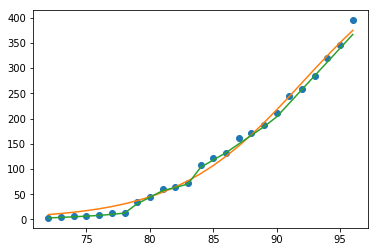

In [232]:
plt.plot(x,y,'o')
plt.plot(x, y_pred)
# plt.plot(x, y_reg)
plt.plot(x, y_pred_cnn)

In [233]:
from sklearn.neural_network import MLPRegressor
x_reg = x_norm.reshape(-1,1)
mlp = MLPRegressor(hidden_layer_sizes=(10,20,10), 
                   tol=1e-4, 
                   max_iter=10000,
                   solver='adam',
                   random_state=0,
                   verbose=1)
mlp.fit(x_reg, y_)

Iteration 1, loss = 15657.89741871
Iteration 2, loss = 15654.43426981
Iteration 3, loss = 15650.92754960
Iteration 4, loss = 15647.40531486
Iteration 5, loss = 15643.85545005
Iteration 6, loss = 15640.24882592
Iteration 7, loss = 15636.62176756
Iteration 8, loss = 15632.94290388
Iteration 9, loss = 15629.21614796
Iteration 10, loss = 15625.43894522
Iteration 11, loss = 15621.57208496
Iteration 12, loss = 15617.66784770
Iteration 13, loss = 15613.67142736
Iteration 14, loss = 15609.62120836
Iteration 15, loss = 15605.46949990
Iteration 16, loss = 15601.22149173
Iteration 17, loss = 15596.88814543
Iteration 18, loss = 15592.38080746
Iteration 19, loss = 15587.82180383
Iteration 20, loss = 15583.22124080
Iteration 21, loss = 15578.58056030
Iteration 22, loss = 15573.89670731
Iteration 23, loss = 15569.17132665
Iteration 24, loss = 15564.40453700
Iteration 25, loss = 15559.60077192
Iteration 26, loss = 15554.73092189
Iteration 27, loss = 15549.81541286
Iteration 28, loss = 15544.85284009
I

Iteration 246, loss = 8111.34469782
Iteration 247, loss = 8032.69984287
Iteration 248, loss = 7953.87118970
Iteration 249, loss = 7874.87127657
Iteration 250, loss = 7795.71284670
Iteration 251, loss = 7716.40884523
Iteration 252, loss = 7636.97199651
Iteration 253, loss = 7557.41390286
Iteration 254, loss = 7477.75021494
Iteration 255, loss = 7397.99469057
Iteration 256, loss = 7318.16126774
Iteration 257, loss = 7238.26406051
Iteration 258, loss = 7158.31735456
Iteration 259, loss = 7078.33560250
Iteration 260, loss = 6998.33341888
Iteration 261, loss = 6918.32557493
Iteration 262, loss = 6838.32699299
Iteration 263, loss = 6758.35274072
Iteration 264, loss = 6678.41802497
Iteration 265, loss = 6598.53818536
Iteration 266, loss = 6518.72868768
Iteration 267, loss = 6439.00511683
Iteration 268, loss = 6359.38316966
Iteration 269, loss = 6279.87864744
Iteration 270, loss = 6200.50744799
Iteration 271, loss = 6121.28555767
Iteration 272, loss = 6042.22904299
Iteration 273, loss = 5963.3

Iteration 486, loss = 491.72181365
Iteration 487, loss = 489.20514210
Iteration 488, loss = 486.68916116
Iteration 489, loss = 484.20030792
Iteration 490, loss = 481.71368339
Iteration 491, loss = 479.21839962
Iteration 492, loss = 476.75189429
Iteration 493, loss = 474.29144441
Iteration 494, loss = 471.82804612
Iteration 495, loss = 469.35164249
Iteration 496, loss = 466.90061749
Iteration 497, loss = 464.44212908
Iteration 498, loss = 461.96389007
Iteration 499, loss = 459.46135560
Iteration 500, loss = 456.95890768
Iteration 501, loss = 454.42228763
Iteration 502, loss = 451.83709542
Iteration 503, loss = 449.23176076
Iteration 504, loss = 446.81235560
Iteration 505, loss = 444.47217588
Iteration 506, loss = 442.14918857
Iteration 507, loss = 439.81467874
Iteration 508, loss = 437.49335432
Iteration 509, loss = 435.15828470
Iteration 510, loss = 432.80861753
Iteration 511, loss = 430.49180115
Iteration 512, loss = 428.16650991
Iteration 513, loss = 425.83118380
Iteration 514, loss 

Iteration 743, loss = 135.36503836
Iteration 744, loss = 134.87622450
Iteration 745, loss = 134.38707972
Iteration 746, loss = 133.91394123
Iteration 747, loss = 133.43410781
Iteration 748, loss = 132.96157961
Iteration 749, loss = 132.49701972
Iteration 750, loss = 132.03614261
Iteration 751, loss = 131.57566495
Iteration 752, loss = 131.12478375
Iteration 753, loss = 130.66171965
Iteration 754, loss = 130.20825584
Iteration 755, loss = 129.78641231
Iteration 756, loss = 129.34278646
Iteration 757, loss = 128.89797790
Iteration 758, loss = 128.47137652
Iteration 759, loss = 128.04221624
Iteration 760, loss = 127.61118362
Iteration 761, loss = 127.19985631
Iteration 762, loss = 126.76831190
Iteration 763, loss = 126.34794003
Iteration 764, loss = 125.94485865
Iteration 765, loss = 125.54029145
Iteration 766, loss = 125.14224229
Iteration 767, loss = 124.73677754
Iteration 768, loss = 124.33781515
Iteration 769, loss = 123.93753002
Iteration 770, loss = 123.53778828
Iteration 771, loss 

Iteration 993, loss = 84.89499209
Iteration 994, loss = 84.81786732
Iteration 995, loss = 84.75799178
Iteration 996, loss = 84.69773541
Iteration 997, loss = 84.63714542
Iteration 998, loss = 84.57629242
Iteration 999, loss = 84.51526306
Iteration 1000, loss = 84.45415322
Iteration 1001, loss = 84.40317147
Iteration 1002, loss = 84.33548487
Iteration 1003, loss = 84.27762164
Iteration 1004, loss = 84.21989339
Iteration 1005, loss = 84.16502723
Iteration 1006, loss = 84.11006389
Iteration 1007, loss = 84.05464429
Iteration 1008, loss = 83.99880795
Iteration 1009, loss = 83.94262211
Iteration 1010, loss = 83.88617367
Iteration 1011, loss = 83.82967316
Iteration 1012, loss = 83.77295450
Iteration 1013, loss = 83.71730362
Iteration 1014, loss = 83.66315761
Iteration 1015, loss = 83.60965631
Iteration 1016, loss = 83.55593964
Iteration 1017, loss = 83.50258477
Iteration 1018, loss = 83.45165973
Iteration 1019, loss = 83.40084286
Iteration 1020, loss = 83.34965250
Iteration 1021, loss = 83.2

Iteration 1257, loss = 75.38969107
Iteration 1258, loss = 75.36034403
Iteration 1259, loss = 75.33121460
Iteration 1260, loss = 75.30191048
Iteration 1261, loss = 75.27453809
Iteration 1262, loss = 75.24450283
Iteration 1263, loss = 75.21618099
Iteration 1264, loss = 75.18783463
Iteration 1265, loss = 75.15945243
Iteration 1266, loss = 75.13102722
Iteration 1267, loss = 75.10255586
Iteration 1268, loss = 75.07403885
Iteration 1269, loss = 75.04547980
Iteration 1270, loss = 75.01688470
Iteration 1271, loss = 74.99685616
Iteration 1272, loss = 74.96094741
Iteration 1273, loss = 74.93360252
Iteration 1274, loss = 74.90616219
Iteration 1275, loss = 74.87858051
Iteration 1276, loss = 74.85082967
Iteration 1277, loss = 74.82289830
Iteration 1278, loss = 74.79478929
Iteration 1279, loss = 74.76651693
Iteration 1280, loss = 74.73810402
Iteration 1281, loss = 74.70957891
Iteration 1282, loss = 74.68118440
Iteration 1283, loss = 74.65235534
Iteration 1284, loss = 74.62371149
Iteration 1285, loss

Iteration 1591, loss = 67.05958946
Iteration 1592, loss = 67.03796240
Iteration 1593, loss = 67.01636079
Iteration 1594, loss = 66.99478822
Iteration 1595, loss = 66.97389302
Iteration 1596, loss = 66.95210373
Iteration 1597, loss = 66.93128465
Iteration 1598, loss = 66.91067706
Iteration 1599, loss = 66.89017611
Iteration 1600, loss = 66.86969094
Iteration 1601, loss = 66.84914874
Iteration 1602, loss = 66.82849666
Iteration 1603, loss = 66.80770194
Iteration 1604, loss = 66.78675051
Iteration 1605, loss = 66.76992776
Iteration 1606, loss = 66.74613340
Iteration 1607, loss = 66.72641918
Iteration 1608, loss = 66.70641420
Iteration 1609, loss = 66.68607187
Iteration 1610, loss = 66.66538225
Iteration 1611, loss = 66.64436573
Iteration 1612, loss = 66.62306572
Iteration 1613, loss = 66.60154098
Iteration 1614, loss = 66.57994026
Iteration 1615, loss = 66.56026398
Iteration 1616, loss = 66.54091210
Iteration 1617, loss = 66.52137509
Iteration 1618, loss = 66.50223309
Iteration 1619, loss

Iteration 1888, loss = 61.98593876
Iteration 1889, loss = 61.96613050
Iteration 1890, loss = 61.94632401
Iteration 1891, loss = 61.92654541
Iteration 1892, loss = 61.90681589
Iteration 1893, loss = 61.88715077
Iteration 1894, loss = 61.87114142
Iteration 1895, loss = 61.84886884
Iteration 1896, loss = 61.83018384
Iteration 1897, loss = 61.81146562
Iteration 1898, loss = 61.79268622
Iteration 1899, loss = 61.77382908
Iteration 1900, loss = 61.75488851
Iteration 1901, loss = 61.73586831
Iteration 1902, loss = 61.71677979
Iteration 1903, loss = 61.69763954
Iteration 1904, loss = 61.67846707
Iteration 1905, loss = 61.65928269
Iteration 1906, loss = 61.64015885
Iteration 1907, loss = 61.62099088
Iteration 1908, loss = 61.60190583
Iteration 1909, loss = 61.58286089
Iteration 1910, loss = 61.56386285
Iteration 1911, loss = 61.54491502
Iteration 1912, loss = 61.52601769
Iteration 1913, loss = 61.50716873
Iteration 1914, loss = 61.48836427
Iteration 1915, loss = 61.46959944
Iteration 1916, loss

Iteration 2169, loss = 57.58628888
Iteration 2170, loss = 57.57263813
Iteration 2171, loss = 57.55995713
Iteration 2172, loss = 57.54516632
Iteration 2173, loss = 57.53171185
Iteration 2174, loss = 57.51836610
Iteration 2175, loss = 57.50501443
Iteration 2176, loss = 57.49155839
Iteration 2177, loss = 57.47792348
Iteration 2178, loss = 57.46406284
Iteration 2179, loss = 57.44995745
Iteration 2180, loss = 57.43561345
Iteration 2181, loss = 57.42105729
Iteration 2182, loss = 57.40632981
Iteration 2183, loss = 57.39147977
Iteration 2184, loss = 57.37655793
Iteration 2185, loss = 57.36161184
Iteration 2186, loss = 57.34574762
Iteration 2187, loss = 57.32445572
Iteration 2188, loss = 57.30222974
Iteration 2189, loss = 57.27926033
Iteration 2190, loss = 57.25534946
Iteration 2191, loss = 57.23083514
Iteration 2192, loss = 57.20568139
Iteration 2193, loss = 57.17994444
Iteration 2194, loss = 57.15367624
Iteration 2195, loss = 57.12692568
Iteration 2196, loss = 57.09973925
Iteration 2197, loss

Iteration 2441, loss = 50.58171088
Iteration 2442, loss = 50.55901387
Iteration 2443, loss = 50.53632939
Iteration 2444, loss = 50.51775005
Iteration 2445, loss = 50.49127450
Iteration 2446, loss = 50.46927820
Iteration 2447, loss = 50.44754485
Iteration 2448, loss = 50.42594375
Iteration 2449, loss = 50.40435638
Iteration 2450, loss = 50.38277153
Iteration 2451, loss = 50.36094059
Iteration 2452, loss = 50.33901034
Iteration 2453, loss = 50.31689007
Iteration 2454, loss = 50.29459924
Iteration 2455, loss = 50.27217674
Iteration 2456, loss = 50.24967275
Iteration 2457, loss = 50.22714092
Iteration 2458, loss = 50.20463147
Iteration 2459, loss = 50.18218609
Iteration 2460, loss = 50.15983474
Iteration 2461, loss = 50.13759438
Iteration 2462, loss = 50.11907792
Iteration 2463, loss = 50.09423733
Iteration 2464, loss = 50.07306653
Iteration 2465, loss = 50.05189491
Iteration 2466, loss = 50.03067212
Iteration 2467, loss = 50.00936362
Iteration 2468, loss = 49.98795213
Iteration 2469, loss

Iteration 2704, loss = 43.85928755
Iteration 2705, loss = 43.83032532
Iteration 2706, loss = 43.80299981
Iteration 2707, loss = 43.77266816
Iteration 2708, loss = 43.74438268
Iteration 2709, loss = 43.71638821
Iteration 2710, loss = 43.68854614
Iteration 2711, loss = 43.66072644
Iteration 2712, loss = 43.63282369
Iteration 2713, loss = 43.60476667
Iteration 2714, loss = 43.57652171
Iteration 2715, loss = 43.54809027
Iteration 2716, loss = 43.51950241
Iteration 2717, loss = 43.49080757
Iteration 2718, loss = 43.46206447
Iteration 2719, loss = 43.43333175
Iteration 2720, loss = 43.40466019
Iteration 2721, loss = 43.37608763
Iteration 2722, loss = 43.35701538
Iteration 2723, loss = 43.32070659
Iteration 2724, loss = 43.29320221
Iteration 2725, loss = 43.26599379
Iteration 2726, loss = 43.23868316
Iteration 2727, loss = 43.21123201
Iteration 2728, loss = 43.18362886
Iteration 2729, loss = 43.15588604
Iteration 2730, loss = 43.12803407
Iteration 2731, loss = 43.10011448
Iteration 2732, loss

Iteration 2993, loss = 36.84833851
Iteration 2994, loss = 36.82661418
Iteration 2995, loss = 36.80493535
Iteration 2996, loss = 36.78331784
Iteration 2997, loss = 36.76176846
Iteration 2998, loss = 36.74028584
Iteration 2999, loss = 36.71886242
Iteration 3000, loss = 36.69748699
Iteration 3001, loss = 36.67650603
Iteration 3002, loss = 36.65484571
Iteration 3003, loss = 36.63355751
Iteration 3004, loss = 36.61228154
Iteration 3005, loss = 36.59101943
Iteration 3006, loss = 36.56977500
Iteration 3007, loss = 36.54855332
Iteration 3008, loss = 36.52735987
Iteration 3009, loss = 36.50619965
Iteration 3010, loss = 36.48507661
Iteration 3011, loss = 36.46399330
Iteration 3012, loss = 36.44295080
Iteration 3013, loss = 36.42194892
Iteration 3014, loss = 36.40380388
Iteration 3015, loss = 36.38086059
Iteration 3016, loss = 36.36113932
Iteration 3017, loss = 36.34157305
Iteration 3018, loss = 36.32193955
Iteration 3019, loss = 36.30207402
Iteration 3020, loss = 36.28188443
Iteration 3021, loss

Iteration 3363, loss = 28.66098089
Iteration 3364, loss = 28.62946888
Iteration 3365, loss = 28.59837919
Iteration 3366, loss = 28.56731578
Iteration 3367, loss = 28.53631925
Iteration 3368, loss = 28.50541851
Iteration 3369, loss = 28.47462799
Iteration 3370, loss = 28.44394795
Iteration 3371, loss = 28.41336753
Iteration 3372, loss = 28.38286929
Iteration 3373, loss = 28.35243412
Iteration 3374, loss = 28.32204555
Iteration 3375, loss = 28.29169266
Iteration 3376, loss = 28.26137145
Iteration 3377, loss = 28.23108445
Iteration 3378, loss = 28.20083927
Iteration 3379, loss = 28.17064630
Iteration 3380, loss = 28.14058838
Iteration 3381, loss = 28.11102046
Iteration 3382, loss = 28.08217286
Iteration 3383, loss = 28.05366983
Iteration 3384, loss = 28.02520861
Iteration 3385, loss = 27.99654613
Iteration 3386, loss = 27.96753518
Iteration 3387, loss = 27.93813533
Iteration 3388, loss = 27.90840088
Iteration 3389, loss = 27.87845279
Iteration 3390, loss = 27.84844285
Iteration 3391, loss

Iteration 3721, loss = 20.00832874
Iteration 3722, loss = 19.99488723
Iteration 3723, loss = 19.98119286
Iteration 3724, loss = 19.96718072
Iteration 3725, loss = 19.95290515
Iteration 3726, loss = 19.93893984
Iteration 3727, loss = 19.92423022
Iteration 3728, loss = 19.91009679
Iteration 3729, loss = 19.89620455
Iteration 3730, loss = 19.88473985
Iteration 3731, loss = 19.86975036
Iteration 3732, loss = 19.85706066
Iteration 3733, loss = 19.84452816
Iteration 3734, loss = 19.83184264
Iteration 3735, loss = 19.81890059
Iteration 3736, loss = 19.80598578
Iteration 3737, loss = 19.79297600
Iteration 3738, loss = 19.77992936
Iteration 3739, loss = 19.76691242
Iteration 3740, loss = 19.75397759
Iteration 3741, loss = 19.74115303
Iteration 3742, loss = 19.72844039
Iteration 3743, loss = 19.71581949
Iteration 3744, loss = 19.70325745
Iteration 3745, loss = 19.69071924
Iteration 3746, loss = 19.67817683
Iteration 3747, loss = 19.66561484
Iteration 3748, loss = 19.65303778
Iteration 3749, loss

Iteration 4055, loss = 16.98764238
Iteration 4056, loss = 16.98244506
Iteration 4057, loss = 16.97726645
Iteration 4058, loss = 16.97210601
Iteration 4059, loss = 16.96696329
Iteration 4060, loss = 16.96186647
Iteration 4061, loss = 16.95675305
Iteration 4062, loss = 16.95168351
Iteration 4063, loss = 16.94663012
Iteration 4064, loss = 16.94159354
Iteration 4065, loss = 16.93657435
Iteration 4066, loss = 16.93157296
Iteration 4067, loss = 16.92658955
Iteration 4068, loss = 16.92162414
Iteration 4069, loss = 16.91667664
Iteration 4070, loss = 16.91181396
Iteration 4071, loss = 16.90685634
Iteration 4072, loss = 16.90198146
Iteration 4073, loss = 16.89712265
Iteration 4074, loss = 16.89228029
Iteration 4075, loss = 16.88745468
Iteration 4076, loss = 16.88264603
Iteration 4077, loss = 16.87785451
Iteration 4078, loss = 16.87308023
Iteration 4079, loss = 16.86832325
Iteration 4080, loss = 16.86360170
Iteration 4081, loss = 16.85888338
Iteration 4082, loss = 16.85419844
Iteration 4083, loss

Iteration 4333, loss = 16.05524242
Iteration 4334, loss = 16.05260357
Iteration 4335, loss = 16.04988584
Iteration 4336, loss = 16.04710117
Iteration 4337, loss = 16.04428631
Iteration 4338, loss = 16.04148493
Iteration 4339, loss = 16.03873059
Iteration 4340, loss = 16.03603650
Iteration 4341, loss = 16.03339457
Iteration 4342, loss = 16.03078249
Iteration 4343, loss = 16.02833628
Iteration 4344, loss = 16.02567764
Iteration 4345, loss = 16.02299977
Iteration 4346, loss = 16.02038999
Iteration 4347, loss = 16.01776837
Iteration 4348, loss = 16.01515174
Iteration 4349, loss = 16.01255345
Iteration 4350, loss = 16.00997930
Iteration 4351, loss = 16.00742696
Iteration 4352, loss = 16.00488849
Iteration 4353, loss = 16.00235444
Iteration 4354, loss = 15.99981769
Iteration 4355, loss = 15.99727573
Iteration 4356, loss = 15.99473083
Iteration 4357, loss = 15.99218832
Iteration 4358, loss = 15.98965418
Iteration 4359, loss = 15.98713272
Iteration 4360, loss = 15.98462536
Iteration 4361, loss

Iteration 4625, loss = 15.54628199
Iteration 4626, loss = 15.54527660
Iteration 4627, loss = 15.54424986
Iteration 4628, loss = 15.54324787
Iteration 4629, loss = 15.54224612
Iteration 4630, loss = 15.54124477
Iteration 4631, loss = 15.54024407
Iteration 4632, loss = 15.53924436
Iteration 4633, loss = 15.53824603
Iteration 4634, loss = 15.53724938
Iteration 4635, loss = 15.53625465
Iteration 4636, loss = 15.53526195
Iteration 4637, loss = 15.53427136
Iteration 4638, loss = 15.53328294
Iteration 4639, loss = 15.53239679
Iteration 4640, loss = 15.53133836
Iteration 4641, loss = 15.53037984
Iteration 4642, loss = 15.52942152
Iteration 4643, loss = 15.52846373
Iteration 4644, loss = 15.52750679
Iteration 4645, loss = 15.52655102
Iteration 4646, loss = 15.52559665
Iteration 4647, loss = 15.52464386
Iteration 4648, loss = 15.52369278
Iteration 4649, loss = 15.52274353
Iteration 4650, loss = 15.52188031
Iteration 4651, loss = 15.52087620
Iteration 4652, loss = 15.51995601
Iteration 4653, loss

Iteration 4875, loss = 15.37593591
Iteration 4876, loss = 15.37550252
Iteration 4877, loss = 15.37506788
Iteration 4878, loss = 15.37463229
Iteration 4879, loss = 15.37419600
Iteration 4880, loss = 15.37375923
Iteration 4881, loss = 15.37340872
Iteration 4882, loss = 15.37291488
Iteration 4883, loss = 15.37250469
Iteration 4884, loss = 15.37209194
Iteration 4885, loss = 15.37167696
Iteration 4886, loss = 15.37126003
Iteration 4887, loss = 15.37084147
Iteration 4888, loss = 15.37042158
Iteration 4889, loss = 15.37000064
Iteration 4890, loss = 15.36957891
Iteration 4891, loss = 15.36915664
Iteration 4892, loss = 15.36881033
Iteration 4893, loss = 15.36834132
Iteration 4894, loss = 15.36794565
Iteration 4895, loss = 15.36754732
Iteration 4896, loss = 15.36714666
Iteration 4897, loss = 15.36674397
Iteration 4898, loss = 15.36633956
Iteration 4899, loss = 15.36593374
Iteration 4900, loss = 15.36552680
Iteration 4901, loss = 15.36511899
Iteration 4902, loss = 15.36471056
Iteration 4903, loss

Iteration 5224, loss = 15.28079864
Iteration 5225, loss = 15.28066129
Iteration 5226, loss = 15.28045348
Iteration 5227, loss = 15.28029353
Iteration 5228, loss = 15.28012895
Iteration 5229, loss = 15.27996013
Iteration 5230, loss = 15.27978750
Iteration 5231, loss = 15.27961149
Iteration 5232, loss = 15.27943254
Iteration 5233, loss = 15.27925102
Iteration 5234, loss = 15.27906728
Iteration 5235, loss = 15.27901167
Iteration 5236, loss = 15.27873103
Iteration 5237, loss = 15.27857534
Iteration 5238, loss = 15.27841497
Iteration 5239, loss = 15.27825032
Iteration 5240, loss = 15.27808177
Iteration 5241, loss = 15.27790974
Iteration 5242, loss = 15.27773463
Iteration 5243, loss = 15.27755685
Iteration 5244, loss = 15.27737674
Iteration 5245, loss = 15.27733304
Iteration 5246, loss = 15.27704781
Iteration 5247, loss = 15.27689578
Iteration 5248, loss = 15.27673895
Iteration 5249, loss = 15.27657776
Iteration 5250, loss = 15.27641262
Iteration 5251, loss = 15.27624396
Iteration 5252, loss

Iteration 5522, loss = 15.24044493
Iteration 5523, loss = 15.24033655
Iteration 5524, loss = 15.24022455
Iteration 5525, loss = 15.24010937
Iteration 5526, loss = 15.23999141
Iteration 5527, loss = 15.23987099
Iteration 5528, loss = 15.23974845
Iteration 5529, loss = 15.23978288
Iteration 5530, loss = 15.23953714
Iteration 5531, loss = 15.23944497
Iteration 5532, loss = 15.23934791
Iteration 5533, loss = 15.23924627
Iteration 5534, loss = 15.23914047
Iteration 5535, loss = 15.23903100
Iteration 5536, loss = 15.23891837
Iteration 5537, loss = 15.23880300
Iteration 5538, loss = 15.23878531
Iteration 5539, loss = 15.23860440
Iteration 5540, loss = 15.23851780
Iteration 5541, loss = 15.23842587
Iteration 5542, loss = 15.23832904
Iteration 5543, loss = 15.23822774
Iteration 5544, loss = 15.23812239
Iteration 5545, loss = 15.23801345
Iteration 5546, loss = 15.23790135
Iteration 5547, loss = 15.23778648
Iteration 5548, loss = 15.23766920
Iteration 5549, loss = 15.23761734
Iteration 5550, loss

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 20, 10), learning_rate='constant',
       learning_rate_init=0.001, max_iter=10000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=0, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=1, warm_start=False)

In [234]:
y_new_pred = mlp.predict(x_reg)
y_new_pred

array([  3.23155461,   4.24698363,   5.52383249,   6.80068136,
         8.07753023,  11.61429389,  18.04728116,  30.61701701,
        43.18675286,  55.75648871,  68.32622456,  80.89832501,
        99.37630759, 117.85429017, 136.33227275, 154.81025533,
       173.28823791, 191.76622049, 210.24420307, 233.84673334,
       263.64428574, 293.44183814, 323.23939054, 353.03694294,
       382.83449533])

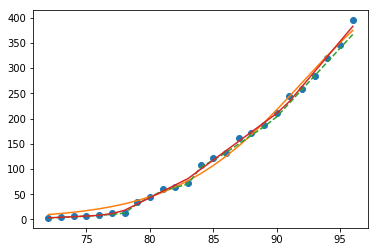

In [235]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
# ax.plot(x, y, '--k')
ax.plot(x, y, 'o')
ax.plot(x, y_pred, '-')
# ax.plot(x, y_reg, '-')
ax.plot(x, y_pred_cnn, '--')
ax.plot(x, y_new_pred, '-')

In [236]:
x_Day = np.array([100])
x_Day = x_Day.reshape(1,-1)
y_day = mlp.predict(x_Day)
y_day

array([17798.2814703])